### Link to the dataset: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pickle

import os
import shutil
from shutil import copyfile

# Functions

## Split data

In [2]:
def create_train_valid_test_dirs(root_path, subdir_names, train_valid_test_names=['train', 'valid', 'test']):
    """ Function for creating separate folders that contain data for training, validation and testing of the model
    Args:
        1) root_path - the path to the parent folder in which you want to create subfolders
        2) subdir_names - a list of label class names (subfolders with the specified names will be created in each of the train, valid, and test folders)
        3) train_valid_test_names - a list of names of training, validation and test samples
    Returns:
        None; but creates folders
    """
    parent_directories = []
    for dir_name in train_valid_test_names:
        parent_directories.append(os.path.join(root_path, dir_name))

    for directory in parent_directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
        for subdirectory in subdir_names:
            subdir_name = os.path.join(directory + '/', subdirectory)
            if not os.path.exists(subdir_name):
                os.makedirs(subdir_name)

In [3]:
def split_data(source_dir_path, train_dir_path, valid_dir_path, test_dir_path, train_test_split=0.8, train_valid_split=0.85, random_sample=True):
    """ Function to split the files of the specified folder into training, validation and test samples by copying 
    the files from source_dir_path to the corresponding folders
    Args:
        1) source_dir_path - the path to the folder containing the original data to be split into train/valid/test
        2) train_dir_path - the path to the folder that will contain the training data
        3) valid_dir_path - the path to the folder that will contain the validation data
        4) test_dir_path - the path to the folder that will contain the test data
        5) train_test_split - the ratio between training and test samples ([0; 1])
        6) train_valid_split - the ratio between training and validation samples ([0; 1])
        7) random_sample - whether files need to be shuffled randomly before splitting into training, validation, and test samples
    Returns:
        None, but split the files into training, validation and test samples
    """
    fnames = os.listdir(source_dir_path)

    processed_fnames = []
    for file_name in fnames:
        if os.path.getsize(os.path.join(source_dir_path, file_name)) > 0:
            processed_fnames.append(file_name)
        else:
            print(f'{file_name} is zero length, so ignoring.')
    
    if random_sample:
        processed_fnames = random.sample(processed_fnames, len(processed_fnames))
        
    split_index = int(train_test_split * len(processed_fnames))
    train_valid_files = processed_fnames[:split_index]
    test_files = processed_fnames[split_index:]
    
    split_index = int(train_valid_split * len(train_valid_files))
    train_files = train_valid_files[:split_index]
    valid_files = train_valid_files[split_index:]
    
    # Copy training files
    for file in train_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(train_dir_path, file)
        copyfile(source, destination)
    
    # Copy validation files
    for file in valid_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(valid_dir_path, file)
        copyfile(source, destination)
    
    # Copy test files
    for file in test_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(test_dir_path, file)
        copyfile(source, destination)
        

In [4]:
def split_class_data(source_dir_path, train_valid_test_paths, class_dir_name, train_test_split=0.8, train_valid_split=0.85, random_sample=True):
    """ Function for dividing the data of one label class into train/valid/test
    Args:
        1) source_dir_path - the path to the folder containing the original data of all label classes which needs to be splitted into train/valid/test;
        2) train_valid_test_paths - the list of paths to the folders of training, validation and test samples 
        (the paths are specified in this order: train, valid, test)
        3) class_dir_name - the name of the folder that contains the label class data
        4) train_test_split - the ratio between training and test samples ([0; 1])
        5) train_valid_split - the ratio between training and validation samples ([0; 1])
        6) random_sample - whether files need to be shuffled randomly before splitting into training, validation, and test samples
    Returns:
        None, but split the files of label class into training, validation and test samples
    """
    train_dir_path_class = os.path.join(train_valid_test_paths[0], class_dir_name)
    valid_dir_path_class = os.path.join(train_valid_test_paths[1], class_dir_name)
    test_dir_path_class = os.path.join(train_valid_test_paths[2], class_dir_name)
    source_dir_path_class = os.path.join(source_dir_path, class_dir_name)
    split_data(source_dir_path=source_dir_path_class, train_dir_path=train_dir_path_class, valid_dir_path=valid_dir_path_class, 
               test_dir_path=test_dir_path_class, 
               train_test_split=train_test_split, train_valid_split=train_valid_split, random_sample=random_sample)

## Display data

In [5]:
def display_image(root_path, image_name, title=None):
    """ Function to display an image
    Args:
        1) root_path - the path to the folder that contains the image
        2) image_name - the name of the image
        3) title - the title that will be displayed above the image
    Returns:
        None; but displays an image
    """
    img = mpimg.imread(os.path.join(root_path, image_name))
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [6]:
def display_pie_chart(df, column_name, title=None, column_contains_count=False, filename=None):
    """ Function to display the percentage ratio of column (with the name column_name) content 
    Args:
        1) df - the original dataframe that contains the required information
        2) column_name - the name of the df dataframe column whose percentage values are to be found
        3) title - the title of the graph
        4) column_contains_count - the dataframe column already contains the number of repetitions of the target values (target value count)
        5) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None, but plots graph
    """
    # Calculate the percentage of each activity in original_df
    if column_contains_count:
        activity_percentages_df = df[column_name] / sum(df[column_name])
    else:
        activity_percentages_df = df[column_name].value_counts(normalize=True) * 100
        
    plt.figure(figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    plt.pie(activity_percentages_df, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()
    
    
def display_pie_charts(first_df, second_df, column, column_contains_count=False, first_chart_title='First DataFrame', second_chart_title='Second DataFrame', filename=None):
    """Function for displaying the ratio of column content between two dataframes in the form of pie charts
    Args:
        1) first_df - the original dataframe that contains the required information
        2) second_df - a dataframe that contains the results of windowing 
        3) column - the name of the dataframe column whose percentage values are to be found
        4) column_contains_count - the dataframe column already contains the number of repetitions of the target values (target value count)
        5) first_chart_title - the title for the first pie chart
        6) second_chart_title - the title for the second pie chart
        7) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None; just builds a pie chart to display the ratio of column contents between two dataframes
    """
    # Calculate the percentage of each activity in first_df
    if column_contains_count:
        activity_percentages_first_df = first_df[column] / sum(first_df[column]) * 100
    else:
        activity_percentages_first_df = first_df[column].value_counts(normalize=True) * 100

    # Calculate the percentage of each activity in second_df
    if column_contains_count:
        activity_percentages_second_df = second_df[column] / sum(second_df[column]) * 100
    else:
        activity_percentages_second_df = second_df[column].value_counts(normalize=True) * 100

    # Create subplots for pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    axes[0].pie(activity_percentages_first_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(first_chart_title)

    # Plot pie chart for windowed_df
    sns.set_palette("Set3")
    axes[1].pie(activity_percentages_second_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(second_chart_title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

## Model training

In [7]:
def plot_graphs(history, strings, filename=None):
    """Function to plot graphs for two training history parameters (eg accuracy and loss)
    Args:
        1) history - model training history
        2) strings - an array of names of history parameters (only the data of the first two history parameters specified in this array will be taken for graphing)
        3) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(history.history[strings[0]], label=strings[0])
    axes[0].plot(history.history[f"val_{strings[0]}"], label=f"val_{strings[0]}")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(strings[0])
    axes[0].legend()
    
    axes[1].plot(history.history[strings[1]], label=strings[1])
    axes[1].plot(history.history[f"val_{strings[1]}"], label=f"val_{strings[1]}")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(strings[1])
    axes[1].legend()
    
    if filename:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
    plt.show()

# Load data

In [ ]:
source_path = 'data/garbage_classification_6_classes/garbage_classification/'

source_path_cardboard = os.path.join(source_path, 'cardboard')
source_path_glass = os.path.join(source_path, 'glass')
source_path_metal = os.path.join(source_path, 'metal')
source_path_paper = os.path.join(source_path, 'paper')
source_path_plastic = os.path.join(source_path, 'plastic')
source_path_trash = os.path.join(source_path, 'trash')

In [ ]:
cardboard_image_names = os.listdir(source_path_cardboard)
glass_image_names = os.listdir(source_path_glass)
metal_image_names = os.listdir(source_path_metal)
paper_image_names = os.listdir(source_path_paper)
plastic_image_names = os.listdir(source_path_plastic)
trash_image_names = os.listdir(source_path_trash)

In [ ]:
print(f"There are {len(cardboard_image_names)} images of cardboard.") # 403
print(f"There are {len(glass_image_names)} images of glass.") # 501
print(f"There are {len(metal_image_names)} images of metal.") # 410
print(f"There are {len(paper_image_names)} images of paper.") # 594
print(f"There are {len(plastic_image_names)} images of plastic.") # 482
print(f"There are {len(trash_image_names)} images of trash.") # 137

## Display classes distribution

In [ ]:
classes_representatives = {'cardboard': len(cardboard_image_names), 
                           'glass': len(glass_image_names),
                           'metal': len(metal_image_names), 
                           'paper': len(paper_image_names),
                           'plastic': len(plastic_image_names), 
                           'trash': len(trash_image_names)
                          }
for label_class in classes_representatives.keys():
    print(f"There are {classes_representatives[label_class]} images of {label_class}.")

In [ ]:
classes_df = pd.DataFrame(list(classes_representatives.items()), columns=['class', 'count'])
classes_df

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.barplot(data=classes_df, x='class', y='count')
plt.title('The number of representatives of the label class (Original dataset)')
plt.savefig('graphs/original_barplot.png')
plt.show()

In [ ]:
display_pie_chart(df=classes_df, column_name='count', title='Percentage ratio between label classes (Original dataset)',
                  column_contains_count=True, filename='graphs/original_piechart')

## Display representatives of each class

### Cardboard

In [ ]:
for cardboard_image_name in cardboard_image_names[:5]:
    display_image(root_path=source_path_cardboard, image_name=cardboard_image_name, title=cardboard_image_name)

### Glass

In [ ]:
for glass_image_name in glass_image_names[:5]:
    display_image(root_path=source_path_glass, image_name=glass_image_name, title=glass_image_name)

### Metal

In [ ]:
for metal_image_name in metal_image_names[:5]:
    display_image(root_path=source_path_metal, image_name=metal_image_name, title=metal_image_name)

### Paper

In [ ]:
for paper_image_name in paper_image_names[:5]:
    display_image(root_path=source_path_paper, image_name=paper_image_name, title=paper_image_name)

### Plastic

In [ ]:
for plastic_image_name in plastic_image_names[:5]:
    display_image(root_path=source_path_plastic, image_name=plastic_image_name, title=plastic_image_name)

### Trash

In [ ]:
for trash_image_name in trash_image_names[:5]:
    display_image(root_path=source_path_trash, image_name=trash_image_name, title=trash_image_name)

# Split data into train, validation and test

## Create folders for train/valid/test data

In [ ]:
destination_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/'

garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
create_train_valid_test_dirs(root_path=destination_path, subdir_names=garbage_class_names)

## Split the data and save it in the appropriate folders

### Split classes data

In [ ]:
train_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/train/'
valid_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/valid/'
test_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/test/'
train_valid_test_paths = [train_dir_path, valid_dir_path, test_dir_path]

for class_name in garbage_class_names:
    split_class_data(source_dir_path=source_path, train_valid_test_paths=train_valid_test_paths, 
                 class_dir_name=class_name, train_test_split=0.9, train_valid_split=0.85, random_sample=False)
    
    class_train_images = os.listdir(os.path.join(train_dir_path, class_name))
    class_valid_images = os.listdir(os.path.join(valid_dir_path, class_name))
    class_test_images = os.listdir(os.path.join(test_dir_path, class_name))

    print(f"{class_name}: train = {len(class_train_images)}") 
    print(f"{class_name}: valid = {len(class_valid_images)}") 
    print(f"{class_name}: test = {len(class_test_images)}") 
    print("")

#### Check classes distribution after spliting

In [ ]:
garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
classes_train_dict = {}
classes_valid_dict = {}
classes_test_dict = {}
for class_name in garbage_class_names:
    classes_train_dict[class_name] = 0
    classes_valid_dict[class_name] = 0
    classes_test_dict[class_name] = 0

In [ ]:
train_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/train/'
valid_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/valid/'
test_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/test/'
train_valid_test_paths = [train_dir_path, valid_dir_path, test_dir_path]

for class_name in garbage_class_names:
    class_train_images = os.listdir(os.path.join(train_dir_path, class_name))
    class_valid_images = os.listdir(os.path.join(valid_dir_path, class_name))
    class_test_images = os.listdir(os.path.join(test_dir_path, class_name))

    classes_train_dict[class_name] = len(class_train_images)
    classes_valid_dict[class_name] = len(class_valid_images)
    classes_test_dict[class_name] = len(class_test_images)

print(f"classes_train_dict = {classes_train_dict}")
print(f"classes_valid_dict = {classes_valid_dict}")
print(f"classes_test_dict = {classes_test_dict}")

In [ ]:
train_classes_df = pd.DataFrame(list(classes_train_dict.items()), columns=['class', 'count'])
valid_classes_df = pd.DataFrame(list(classes_valid_dict.items()), columns=['class', 'count'])
test_classes_df = pd.DataFrame(list(classes_test_dict.items()), columns=['class', 'count'])

train_classes_df

##### Train data

In [ ]:
display_pie_chart(df=train_classes_df, column_name='count', title='Percentage ratio between label classes (Train dataset)',
                  column_contains_count=True, filename='graphs/train_piechart')

In [ ]:
display_pie_charts(first_df=classes_df, second_df=train_classes_df, column='count',
                   column_contains_count=True, 
                   first_chart_title='Original Data', second_chart_title='Train Data', 
                   filename='graphs/original_vs_train_piecharts')

##### Valid data

In [ ]:
display_pie_chart(df=valid_classes_df, column_name='count', title='Percentage ratio between label classes (Validation dataset)',
                  column_contains_count=True, filename='graphs/validation_piechart')

In [ ]:
display_pie_charts(first_df=classes_df, second_df=valid_classes_df, column='count',
                   column_contains_count=True, 
                   first_chart_title='Original Data', second_chart_title='Valid Data', 
                   filename='graphs/original_vs_valid_piecharts')

##### Test data

In [ ]:
display_pie_chart(df=test_classes_df, column_name='count', title='Percentage ratio between label classes (Test dataset)',
                  column_contains_count=True, filename='graphs/test_piechart')

In [ ]:
display_pie_charts(first_df=classes_df, second_df=test_classes_df, column='count',
                   column_contains_count=True, 
                   first_chart_title='Original Data', second_chart_title='Test Data', 
                   filename='graphs/original_vs_test_piecharts')

# Train CNN model

## Create train and valid datagenerators

In [8]:
train_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/train/'
valid_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/valid/'
test_dir_path = 'data/garbage_classification_6_classes/garbage_classification_TrainValidTest/test/'

train_datagen = ImageDataGenerator(rescale=(1./255.))
train_generator = train_datagen.flow_from_directory(directory=train_dir_path,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))

valid_datagen = ImageDataGenerator(rescale=(1./255.))
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir_path,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))

Found 1927 images belonging to 6 classes.
Found 344 images belonging to 6 classes.


## Train the model

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [10]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

In [11]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
my_callback = myCallback()

In [12]:
model.compile(optimizer=tf.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [13]:
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    validation_data=valid_generator,
                    callbacks=[early_stopping_callback, my_callback])

Epoch 1/30
31/31 [==============================] - 144s 5s/step - loss: 1.7064 - accuracy: 0.2631 - val_loss: 1.4895 - val_accuracy: 0.4419
Epoch 2/30
31/31 [==============================] - 132s 4s/step - loss: 1.4143 - accuracy: 0.4312 - val_loss: 1.3351 - val_accuracy: 0.4273
Epoch 3/30
31/31 [==============================] - 133s 4s/step - loss: 1.2691 - accuracy: 0.4847 - val_loss: 1.2637 - val_accuracy: 0.5058
Epoch 4/30
31/31 [==============================] - 131s 4s/step - loss: 1.1773 - accuracy: 0.5355 - val_loss: 1.3063 - val_accuracy: 0.5145
Epoch 5/30
31/31 [==============================] - 134s 4s/step - loss: 1.0869 - accuracy: 0.6025 - val_loss: 1.2080 - val_accuracy: 0.5349
Epoch 6/30
31/31 [==============================] - 135s 4s/step - loss: 1.0087 - accuracy: 0.6175 - val_loss: 1.1592 - val_accuracy: 0.5465
Epoch 7/30
31/31 [==============================] - 139s 4s/step - loss: 0.8480 - accuracy: 0.6881 - val_loss: 1.2120 - val_accuracy: 0.5523
Epoch 8/30
31

## Display results of training

### Display the training history

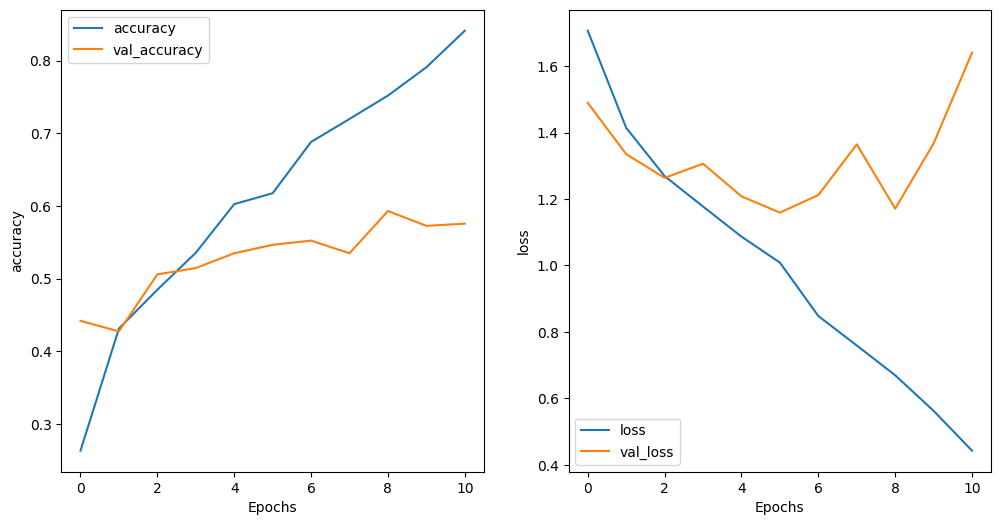

In [14]:
plot_graphs(history=history, strings=['accuracy', 'loss'], filename='graphs/training_history')

### Save the model

In [15]:
model.save('models/2_garbage_classification_6_classes_model.h5')

E:\MyLearning\Programming\DS_ML\Courses\DS_Bootcamp_2023\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
with open('models/histories/2_garbage_classification_6_classes_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)